In [4]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import operator
from typing import Annotated

from langchain_core.pydantic_v1 import BaseModel, Field

In [26]:
# ロール
ROLES = {
    "1": {
        "name": "一般知識エキスパート",
        "description": "幅広い分野の一般的な質問に答える",
        "details": "幅広い分野の一般的な質問に対して、正確で分かりやすい回答を提供してください。"
    },
    "2": {
        "name": "生成AI製品エキスパート",
        "description": "生成AIや関連製品、技術に関する専門的な質問に答える",
        "details": "生成AIや関連製品、技術に関する専門的な質問に対して、最新の情報と深い洞察を提供してください。"
    },
    "3": {
        "name": "カウンセラー",
        "description": "個人的な悩みや心理的な問題に対してサポートを提供する",
        "details": "個人的な悩みや心理的な問題に対して、共感的で支援的な回答を提供し、可能であれば適切なアドバイスも行ってください。"
    }
}

In [63]:
# state

class State(BaseModel):
    query: str = Field(..., description="ユーザーからの質問")
    current_role: str = Field(
        default="", description="選定された回答ロール"
    )
    messages: Annotated[list[str], operator.add] = Field(default=[], description="回答履歴")
    current_judge: bool = Field(
        default=False, description="品質チェックの結果"
    )
    judgement_reason: str = Field(
        default="", description="品質チェックの判定理由"
    )

In [64]:
# llm

from langchain_openai import ChatOpenAI
from langchain_core.runnables import ConfigurableField


llm = ChatOpenAI(model="gpt-4o", temperature=0.0)

# Maxtokenは後から変更可能にするためのフィールドを宣言
llm = llm.configurable_fields(max_tokens=ConfigurableField(id='max_tokens'))

### nodeの作成

In [65]:
# selection

from typing import Any

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

def selection_node(state:State) -> dict[str, Any]:
    query = state.query
    role_options = "\n".join( f"{k}.{v['name']}: {v['description']}" for k, v in ROLES.items())
    prompt = ChatPromptTemplate.from_template(
        """質問を分析し、最も適切な回答担当ロールを選択してください。

        選択技:
        {role_options}

        回答は選択技の（1, 2, または3）のみ返してください。

        質問: {query}
        
        """.strip()
    )

    # 選択肢の番号のみを返すことにしたいので、max_tokensを1にする
    chain = prompt | llm.with_config(configurable=dict(max_tokens=1)) | StrOutputParser()
    role_number = chain.invoke({"role_options": role_options, "query": query})

    selected_role = ROLES[role_number.strip()]['name']
    return {"current_role": selected_role}
    

In [66]:
# answering

def answering_node(state: State) -> dict[str, Any]:
    query = state.query
    role = state.current_role
    role_details = "\n".join([f"- {v['name']}: {v['details']}" for v in ROLES.values()])
    prompt = ChatPromptTemplate.from_template(
"""あなたは{role}として回答してください。以下の質問に対して、あなたの役割に基づいた適切な回答を提供してください。

役割の詳細:
{role_details}

質問: {query}

回答:""".strip()
    )
    chain = prompt | llm | StrOutputParser()
    answer = chain.invoke({"role": role, "role_details": role_details, "query": query})
    return {"messages": [answer]} 

In [67]:
# chack

class Judgement(BaseModel):
    reason: str = Field(default="", description="判定理由")
    judge: bool = Field(default=False, description="判定結果")

def check_node(state: State) -> dict[str, Any]:
    query = state.query
    answer = state.messages[-1]
    prompt = ChatPromptTemplate.from_template(
"""以下の回答の品質をチェックし、問題がある場合は'False'、問題がない場合は'True'を回答してください。
また、その判断理由も説明してください。

ユーザーからの質問: {query}
回答: {answer}
""".strip()
    )
    chain = prompt | llm.with_structured_output(Judgement)
    result: Judgement = chain.invoke({"query": query, "answer": answer})

    return {
        "current_judge": result.judge,
        "judgement_reason": result.reason
    }

In [68]:
# グラフのインスタンス化
workflow = StateGraph(State)

In [69]:
# nodeの追加
workflow.add_node("selection", selection_node)
workflow.add_node("answering", answering_node)
workflow.add_node("check", check_node)

In [70]:
# edge
# selectionノードから処理を開始
workflow.set_entry_point("selection")

In [71]:
# selectionノードからansweringノードへ
workflow.add_edge("selection", "answering")
# answeringノードからcheckノードへ
workflow.add_edge("answering", "check")

In [72]:
from langgraph.graph import END

workflow.add_conditional_edges(
    "check",
    lambda state: state.current_judge,
    {True: END, False: "selection"}
)


In [73]:
compiled = workflow.compile()

In [74]:
# 引数には初期ステートを渡す必要がある。
inital_state = State(query="生成AIについて教えてください。")

result = compiled.invoke(inital_state)

In [39]:
result

{'query': '生成AIについて教えてください。',
 'current_role': '生成AI製品エキスパート',
 'messages': ['生成AI製品エキスパートとしてお答えします。\n\n生成AI（生成的人工知能）は、データから新しいコンテンツを生成する能力を持つAI技術の一分野です。これには、テキスト、画像、音声、音楽など、さまざまな形式のコンテンツが含まれます。生成AIの代表的な技術には、以下のようなものがあります。\n\n1. **GPT（Generative Pre-trained Transformer）**: これは、自然言語処理に特化したモデルで、テキストの生成や翻訳、要約などに利用されます。OpenAIのGPTシリーズが有名です。\n\n2. **GAN（Generative Adversarial Networks）**: これは、2つのニューラルネットワークが競い合うことで、リアルなデータを生成する技術です。画像生成や映像の合成に多く使われています。\n\n3. **VAE（Variational Autoencoders）**: これは、データの潜在的な特徴を学習し、新しいデータを生成するためのモデルです。主に画像生成に利用されます。\n\n生成AIは、クリエイティブな分野での応用が進んでおり、アートや音楽の制作、広告やマーケティングコンテンツの自動生成、さらにはゲーム開発など、多岐にわたる分野で活用されています。また、医療や教育などの分野でも、データのシミュレーションやパーソナライズされたコンテンツの提供に役立っています。\n\n生成AIの進化により、より自然で人間らしいコンテンツの生成が可能になりつつありますが、倫理的な課題やデータの偏りといった問題も存在します。これらの課題に対処しながら、生成AIの可能性を最大限に引き出すことが求められています。'],
 'current_judge': True,
 'judgement_reason': '回答は生成AIについての基本的な情報を網羅しており、具体的な技術例（GPT、GAN、VAE）を挙げて説明しています。また、生成AIの応用分野や課題についても触れており、全体的にバランスの取れた内容です。特に誤った情報や不適切な表現は見当たりません。'}

In [40]:
print(result["messages"][-1])

生成AI製品エキスパートとしてお答えします。

生成AI（生成的人工知能）は、データから新しいコンテンツを生成する能力を持つAI技術の一分野です。これには、テキスト、画像、音声、音楽など、さまざまな形式のコンテンツが含まれます。生成AIの代表的な技術には、以下のようなものがあります。

1. **GPT（Generative Pre-trained Transformer）**: これは、自然言語処理に特化したモデルで、テキストの生成や翻訳、要約などに利用されます。OpenAIのGPTシリーズが有名です。

2. **GAN（Generative Adversarial Networks）**: これは、2つのニューラルネットワークが競い合うことで、リアルなデータを生成する技術です。画像生成や映像の合成に多く使われています。

3. **VAE（Variational Autoencoders）**: これは、データの潜在的な特徴を学習し、新しいデータを生成するためのモデルです。主に画像生成に利用されます。

生成AIは、クリエイティブな分野での応用が進んでおり、アートや音楽の制作、広告やマーケティングコンテンツの自動生成、さらにはゲーム開発など、多岐にわたる分野で活用されています。また、医療や教育などの分野でも、データのシミュレーションやパーソナライズされたコンテンツの提供に役立っています。

生成AIの進化により、より自然で人間らしいコンテンツの生成が可能になりつつありますが、倫理的な課題やデータの偏りといった問題も存在します。これらの課題に対処しながら、生成AIの可能性を最大限に引き出すことが求められています。


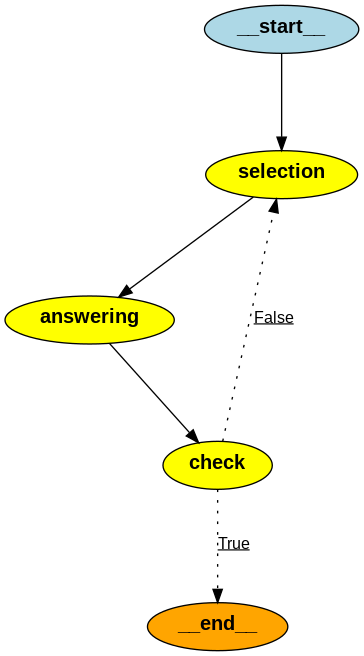

In [49]:
# 作成したグラフの描画
from IPython.display import Image

Image(compiled.get_graph().draw_png())

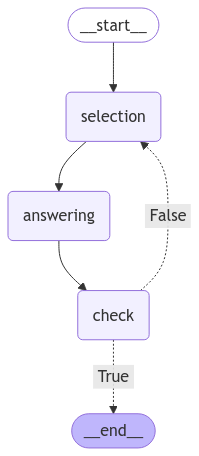

In [50]:
Image(compiled.get_graph().draw_mermaid_png())

## checkpoint

In [94]:
import operator
from typing import Any, Annotated
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

# state
class State(BaseModel):
    query: str
    messages: Annotated[list[BaseModel], operator.add] = Field(default=[])

def add_message(state: State) -> dict[str, Any]:
    additional_messages = []
    if not state.messages:
        additional_messages.append(
            SystemMessage(content="あなたは最小限の応答をする対話エージェントです。")
        )
    additional_messages.append(HumanMessage(content=state.query))
    return {"messages": additional_messages}

def llm_response(state: State) -> dict[str, Any]:
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
    ai_message = llm.invoke(state.messages)
    return {"messages": [ai_message]}

In [95]:
# checkpoint

from pprint import pprint
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.base import BaseCheckpointSaver

def print_checkpoint_dump(ckeckpointer: BaseCheckpointSaver, config: RunnableConfig):
    checkpoint_tuple = checkpointer.get_tuple(config)

    print('チェックポイントデータ')
    pprint(checkpoint_tuple.checkpoint)
    print('\nメタデータ:')
    pprint(checkpoint_tuple.metadata)

In [96]:
# グラフの作成、コンパイル
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

graph = StateGraph(State)
graph.add_node("add_message", add_message)
graph.add_node("llm_response", llm_response)

graph.set_entry_point("add_message")
graph.add_edge("add_message", "llm_response")
graph.add_edge("llm_response", END)


checkpointer = MemorySaver()


compiled_graph = graph.compile(checkpointer=checkpointer)

In [97]:
config = {"configurable": {"thread_id": "example-1"}}

user_query = State(query="私の好きなものはずんだもちです。覚えておいてね。")
first_respose = compiled_graph.invoke(user_query, config)

In [98]:
first_respose

{'query': '私の好きなものはずんだもちです。覚えておいてね。',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだもちです。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='ずんだもち、覚えました！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 47, 'total_tokens': 57, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logprobs': None}, id='run-e2bbde1b-2c34-4444-9518-f2c43a3648af-0', usage_metadata={'input_tokens': 47, 'output_tokens': 10, 'total_tokens': 57, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [101]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1efc7235-ec64-632c-8002-7a52a93769bc'}}, checkpoint={'v': 1, 'ts': '2024-12-31T03:00:19.960884+00:00', 'id': '1efc7235-ec64-632c-8002-7a52a93769bc', 'channel_values': {'query': '私の好きなものはずんだもちです。覚えておいてね。', 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}), HumanMessage(content='私の好きなものはずんだもちです。覚えておいてね。', additional_kwargs={}, response_metadata={}), AIMessage(content='ずんだもち、覚えました！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 47, 'total_tokens': 57, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logp

In [102]:
print_checkpoint_dump(checkpointer, config)

チェックポイントデータ
{'channel_values': {'llm_response': 'llm_response',
                    'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私の好きなものはずんだもちです。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='ずんだもち、覚えました！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 47, 'total_tokens': 57, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logprobs': None}, id='run-e2bbde1b-2c34-4444-9518-f2c43a3648af-0', usage_metadata={'input_tokens': 47, 'output_tokens': 10, 'total_tokens': 57, 'input_token_details'

In [103]:
user_query = State(query="私の好物は何か覚えてる？")
second_response = compiled_graph.invoke(user_query, config)
second_response

{'query': '私の好物は何か覚えてる？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだもちです。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='ずんだもち、覚えました！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 47, 'total_tokens': 57, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logprobs': None}, id='run-e2bbde1b-2c34-4444-9518-f2c43a3648af-0', usage_metadata={'input_tokens': 47, 'output_tokens': 10, 'total_tokens': 57, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='私の好物は何

In [104]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1efc724e-a99f-68f2-8006-9c173a1a46f6'}}, checkpoint={'v': 1, 'ts': '2024-12-31T03:11:24.048378+00:00', 'id': '1efc724e-a99f-68f2-8006-9c173a1a46f6', 'channel_values': {'query': '私の好物は何か覚えてる？', 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}), HumanMessage(content='私の好きなものはずんだもちです。覚えておいてね。', additional_kwargs={}, response_metadata={}), AIMessage(content='ずんだもち、覚えました！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 47, 'total_tokens': 57, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logprobs': None}

In [105]:
print_checkpoint_dump(checkpointer, config)

チェックポイントデータ
{'channel_values': {'llm_response': 'llm_response',
                    'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私の好きなものはずんだもちです。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='ずんだもち、覚えました！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 47, 'total_tokens': 57, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logprobs': None}, id='run-e2bbde1b-2c34-4444-9518-f2c43a3648af-0', usage_metadata={'input_tokens': 47, 'output_tokens': 10, 'total_tokens': 57, 'input_token_details'

In [106]:
config = {"configurable": {"thread_id": "example-2"}}
user_query = State(query="私の好物は何？")
other_thread_response = compiled_graph.invoke(user_query, config)
other_thread_response

{'query': '私の好物は何？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好物は何？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='わかりません。あなたの好物は何ですか？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 36, 'total_tokens': 51, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logprobs': None}, id='run-00076858-b38d-4c41-8691-cf051c06b980-0', usage_metadata={'input_tokens': 36, 'output_tokens': 15, 'total_tokens': 51, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}